# Lecture 6 Slides: Good & Bad Controls

https://www.youtube.com/watch?v=NSuTaeW6Orc&list=PLDcUM9US4XdMROZ57-OIRtIK0aOynbgZN&index=7

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import altair as alt

alt.renderers.enable("mimetype")  # support rendering on github

import numpy as np
import pandas as pd

import statreth as sr
from statreth.utils import suppress_subprocess_output

In [3]:
# workaround to make stan run in jupyter
# https://pystan.readthedocs.io/en/latest/faq.html#how-can-i-use-pystan-with-jupyter-notebook-or-jupyterlab
import nest_asyncio
import stan

nest_asyncio.apply()
del nest_asyncio

## Estimate **direct** effect of grandparents `G` on grandchildren `C`.

To find `C = f(G | direct)` we need to block  `G->P->C` by conditioning on `P` but `P` is a collider of `G` and `U` which would make them associated. So knowing `P` would reveal some information about `U` and bias `C`.
```
G────►P◄────U
│     │     │
│     │     │
│     ▼     │
└────►C◄────┘
```

In this context we can only estimate the total effect `C = f(G)` or biased direct effect `C = f(G, P)` due to `U`.

In [4]:
# generate synthetic data so we have exact model
n = 200  # number of grandparent-parent-child triplets
b_GP = 1  # direct effect of G on P
b_GC = 0  # direct effect of G on C
b_PC = 1  # direct effect of P on C
b_U = 2  # direct effect of U on P and C

In [5]:
U = 2 * np.random.binomial(n=1, p=0.5, size=n) - 1  # [-1, 1], neighbourhood impact
G = np.random.normal(0, 1, size=n)  # grandparent education level
P = np.random.normal(b_GP * G + b_U * U, 1, size=n)  # parent education level
C = np.random.normal(b_PC * P + b_GC * G + b_U * U, 1, size=n)  # child education level

edu_df = pd.DataFrame({"grandparent": G, "parent": P, "child": C, "neighborhood": U})
edu_df.head(5)

,grandparent,parent,child,neighborhood
0,-0.262717,-2.781279,-4.172667,-1
1,1.485307,3.500158,5.630318,1
2,-0.432645,2.608126,4.988597,1
3,-0.142252,1.122703,1.669410,1
4,0.054049,-2.795579,-2.837197,-1


In [6]:
# Build a model for C = f(G, P). Expect to get biased results.
code = """
data {
  int<lower=0> n;  // number of families
  vector[n] G;     // grandparent education
  vector[n] P;     // parent education
  vector[n] C;     // child education
}
parameters {
  real<lower=0> a;  // default child education
  real b_PC;        // parent->child slope
  real b_GC;        // grandparent->child slope
  real<lower=0> sigma;
}
model {
  // priors
  a ~ lognormal(0, 1);
  b_PC ~ normal(0, 1);
  b_GC ~ normal(0, 1);
  sigma ~ exponential(1);
  
  // likelihood
  vector[n] myu = a + b_PC * P + b_GC * G;
  C ~ normal(myu, sigma);
}
"""

data = {"n": n, "G": G, "P": P, "C": C}

In [7]:
%%capture
with suppress_subprocess_output():
    model = stan.build(code, data=data, random_seed=42)

In [8]:
%%capture
fit = model.sample(num_chains=4, num_samples=1000)

In [9]:
fit_df = fit.to_frame()
fit_df[["a", "b_PC", "b_GC", "sigma"]].describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
a,4000.0,0.132317,0.056333,0.014942,0.090661,0.126365,0.166856,0.389990
b_PC,4000.0,1.764829,0.044772,1.578698,1.734871,1.765147,1.795199,1.948148
b_GC,4000.0,-0.668023,0.107812,-1.077744,-0.738951,-0.666609,-0.596243,-0.270096
sigma,4000.0,1.339088,0.069612,1.148443,1.290340,1.335160,1.383442,1.617383


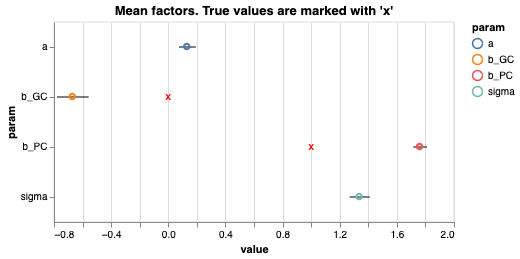

In [10]:
df = fit_df[["a", "b_PC", "b_GC", "sigma"]][:1200]

df = df.melt(var_name="param")

error_bars = alt.Chart(df).mark_errorbar(extent="stdev").encode(x="value", y="param")

points = (
    alt.Chart(df)
    .mark_point(filled=False)
    .encode(x=alt.X("value", aggregate="mean"), y="param", color="param")
)

text = (
    alt.Chart(pd.DataFrame({"param": ["b_GC", "b_PC"], "value": [b_GC, b_PC]}))
    .mark_text(dy=0, color="red")
    .encode(x="value", y="param", text=alt.value("x"))
)

(error_bars + points + text).properties(
    width=400, height=200, title="Mean factors. True values are marked with 'x'"
)

In [11]:
from scipy.stats import linregress

In [13]:
qlow, qhigh = [0.45, 0.60] # percentiles range
plow = float(np.quantile(edu_df["parent"], qlow))
phigh = float(np.quantile(edu_df["parent"], qhigh))

mask = (edu_df["parent"] > plow) & (edu_df["parent"] < phigh)
mask.mean()

np.float64(0.15)

In [14]:
# fit regression line to selected families
g = edu_df["grandparent"][mask]
c = edu_df["child"][mask]

res = linregress(g, c)

In [15]:
grandparent_x = np.linspace(g.min(), g.max())
child_y = res.intercept + grandparent_x * res.slope

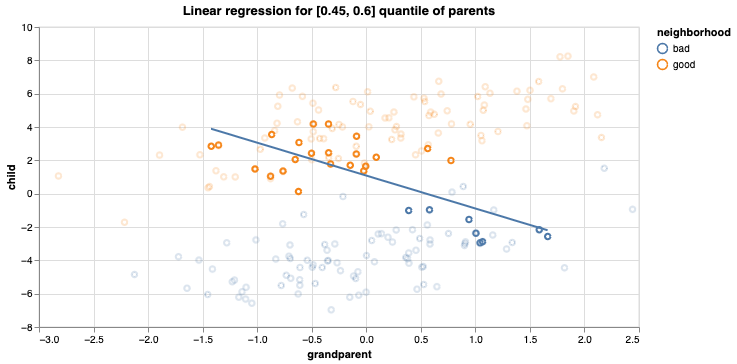

In [16]:
df = edu_df.copy()
df["neighborhood"] = df["neighborhood"].map(lambda n: {-1: "bad", 1: "good"}[n])

line = (
    alt.Chart(pd.DataFrame({"grandparent": grandparent_x, "child": child_y}))
    .mark_line()
    .encode(x="grandparent", y="child")
)

edu_chart = (
    alt.Chart(df, width=600, title=f"Linear regression for [{qlow}, {qhigh}] quantile of parents")
    .mark_point()
    .encode(
        x="grandparent",
        y="child",
        color="neighborhood:N",
        opacity=alt.condition(
            (alt.datum.parent > plow) & (alt.datum.parent < phigh),
            alt.value(1.0),
            alt.value(0.2),
        ),
    )
)
edu_chart + line